In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
sentiments = pd.read_csv('combined_sentiments.csv')

sentiments['dominant_emotion_a'] = sentiments['dominant_emotion_a'].fillna('None')
sentiments['dominant_emotion_p'] = sentiments['dominant_emotion_p'].fillna('None')

sentiments["publishingDate"] = pd.to_datetime(sentiments["publishingDate"])
sentiments["CreatedAt"] = pd.to_datetime(sentiments["CreatedAt"])

emotion_cols_a = ["anger_a", "fear_a", "disgust_a", "sadness_a", "joy_a", "none_a"]
emotion_cols_p = ["anger_p", "fear_p", "disgust_p", "sadness_p", "joy_p", "none_p"]

sentiments_filtered = sentiments[(sentiments["publishingDate"] >= "2015-07-01") &
                                  (sentiments["CreatedAt"] >= "2015-07-01")&
                                  (sentiments["publishingDate"] <= "2016-05-01") &
                                  (sentiments["CreatedAt"] <= "2016-05-01")]

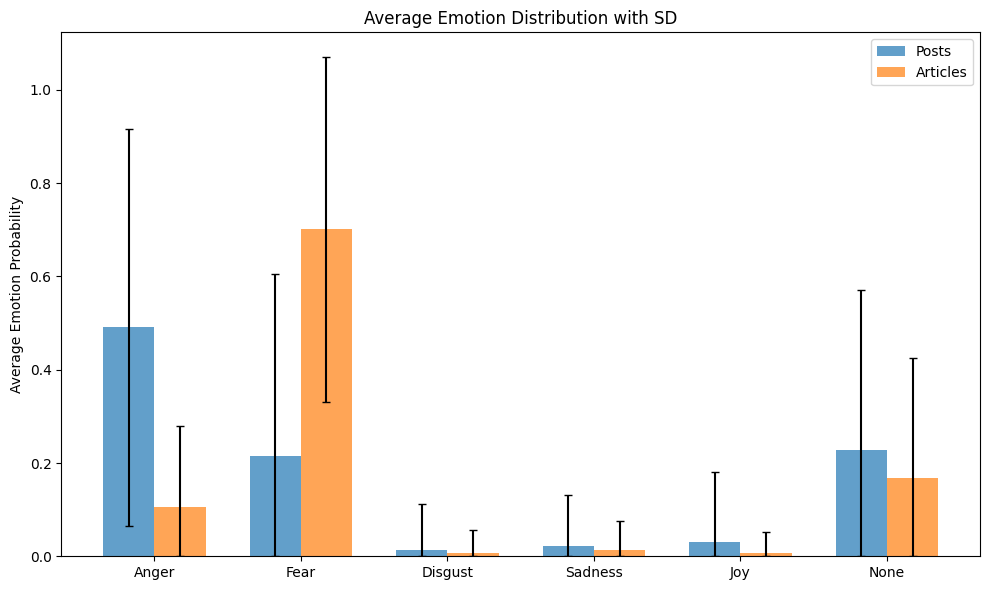

In [3]:
post_avg = sentiments_filtered[emotion_cols_p].mean()
article_avg = sentiments_filtered[emotion_cols_a].mean()

post_std = sentiments_filtered[emotion_cols_p].std()
article_std = sentiments_filtered[emotion_cols_a].std()

post_err_lower = np.minimum(post_std, post_avg)  # can't go below 0
article_err_lower = np.minimum(article_std, article_avg)

fig, ax = plt.subplots(figsize=(10,6))
width = 0.35
x = np.arange(len(emotion_cols_a))

ax.bar(x - width/2, post_avg, width, label='Posts', alpha=0.7,
       yerr=[post_err_lower, post_std], capsize=3)
ax.bar(x + width/2, article_avg, width, label='Articles', alpha=0.7,
       yerr=[article_err_lower, article_std], capsize=3)

ax.set_xticks(x)
ax.set_xticklabels([e.replace("_a","").capitalize() for e in emotion_cols_a])
ax.set_ylabel("Average Emotion Probability")
ax.set_title("Average Emotion Distribution with SD")
ax.legend()
plt.tight_layout()
plt.show()


In [4]:
topic_avg_posts = sentiments_filtered.groupby('NewsroomTopic')[emotion_cols_p].mean().reset_index()
topic_sd_posts  = sentiments_filtered.groupby('NewsroomTopic')[emotion_cols_p].sem().reset_index()

df_posts_long = topic_avg_posts.melt(
    id_vars='NewsroomTopic',
    value_vars=emotion_cols_p,
    var_name='Emotion',
    value_name='Mean'
)

df_posts_long['SD'] = topic_sd_posts.melt(
    id_vars='NewsroomTopic',
    value_vars=emotion_cols_p
)['value']

df_posts_long['Emotion'] = df_posts_long['Emotion'].str.replace("_p", "").str.capitalize()

df_posts_long['err_minus'] = np.minimum(df_posts_long['SD'], df_posts_long['Mean'])
df_posts_long['err_plus']  = np.minimum(df_posts_long['SD'], 1 - df_posts_long['Mean'])

fig = px.bar(
    df_posts_long,
    x='NewsroomTopic',
    y='Mean',
    color='Emotion',
    barmode='group',
    opacity=0.7,
    error_y='err_plus',
    error_y_minus='err_minus',
    title="Average Post Emotions by Newsroom Topic with SD"
)
fig.update_traces(
    error_y=dict(thickness=1, width=2),
    selector=dict(type='bar')
)
fig.show()

topic_avg_articles = sentiments_filtered.groupby('NewsroomTopic')[emotion_cols_a].mean().reset_index()
topic_sd_articles  = sentiments_filtered.groupby('NewsroomTopic')[emotion_cols_a].std().reset_index()

df_articles_long = topic_avg_articles.melt(
    id_vars='NewsroomTopic',
    value_vars=emotion_cols_a,
    var_name='Emotion',
    value_name='Mean'
)
df_articles_long['SD'] = topic_sd_articles.melt(
    id_vars='NewsroomTopic',
    value_vars=emotion_cols_a
)['value']

df_articles_long['Emotion'] = df_articles_long['Emotion'].str.replace("_a", "").str.capitalize()

df_articles_long['err_minus'] = np.minimum(df_articles_long['SD'], df_articles_long['Mean'])
df_articles_long['err_plus']  = np.minimum(df_articles_long['SD'], 1 - df_articles_long['Mean'])

fig = px.bar(
    df_articles_long,
    x='NewsroomTopic',
    y='Mean',
    color='Emotion',
    barmode='group',
    opacity=0.7,
    error_y='err_plus',
    error_y_minus='err_minus',
    title="Average Article Emotions by Newsroom Topic with SD"
)
fig.update_traces(
    error_y=dict(thickness=1, width=2),
    selector=dict(type='bar')
)
fig.show()


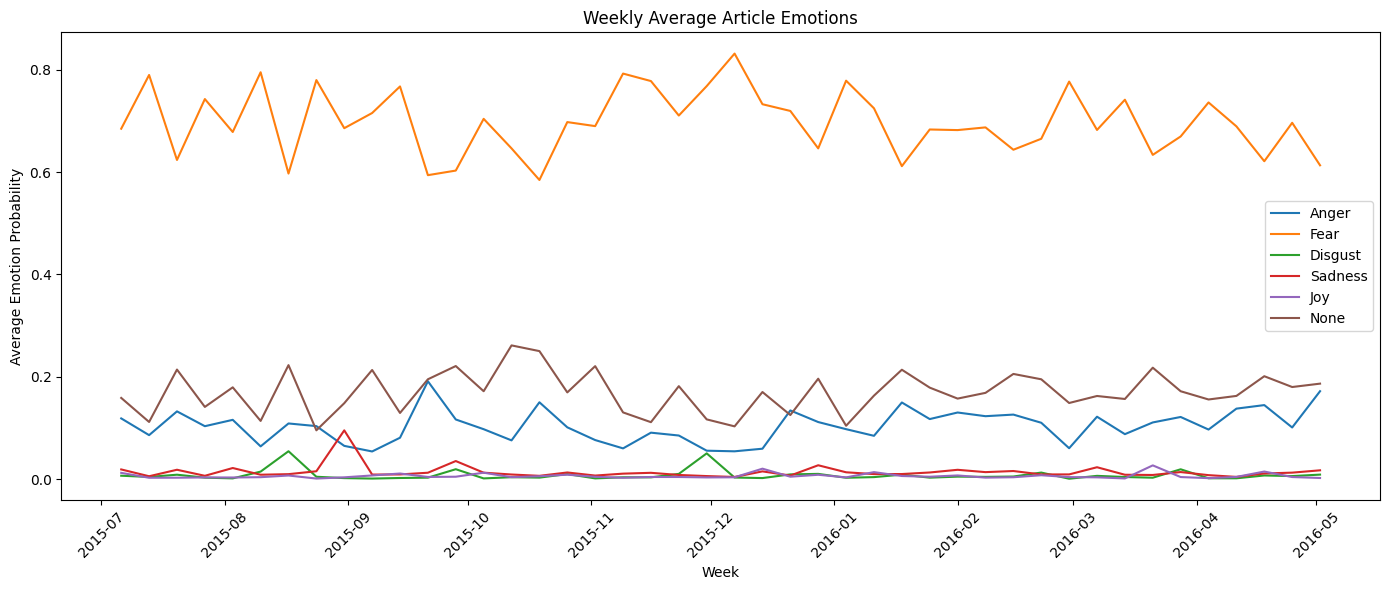

In [5]:
weekly_emotions_a = (
    sentiments_filtered.groupby(pd.Grouper(key='publishingDate', freq='W-MON'))[emotion_cols_a]
    .mean().reset_index().rename(columns={'publishingDate': 'Week'})
)

plt.figure(figsize=(14,6))
for col in emotion_cols_a:
    plt.plot(weekly_emotions_a['Week'], weekly_emotions_a[col], label=col.replace("_a","").capitalize())
plt.xlabel("Week")
plt.ylabel("Average Emotion Probability")
plt.title("Weekly Average Article Emotions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

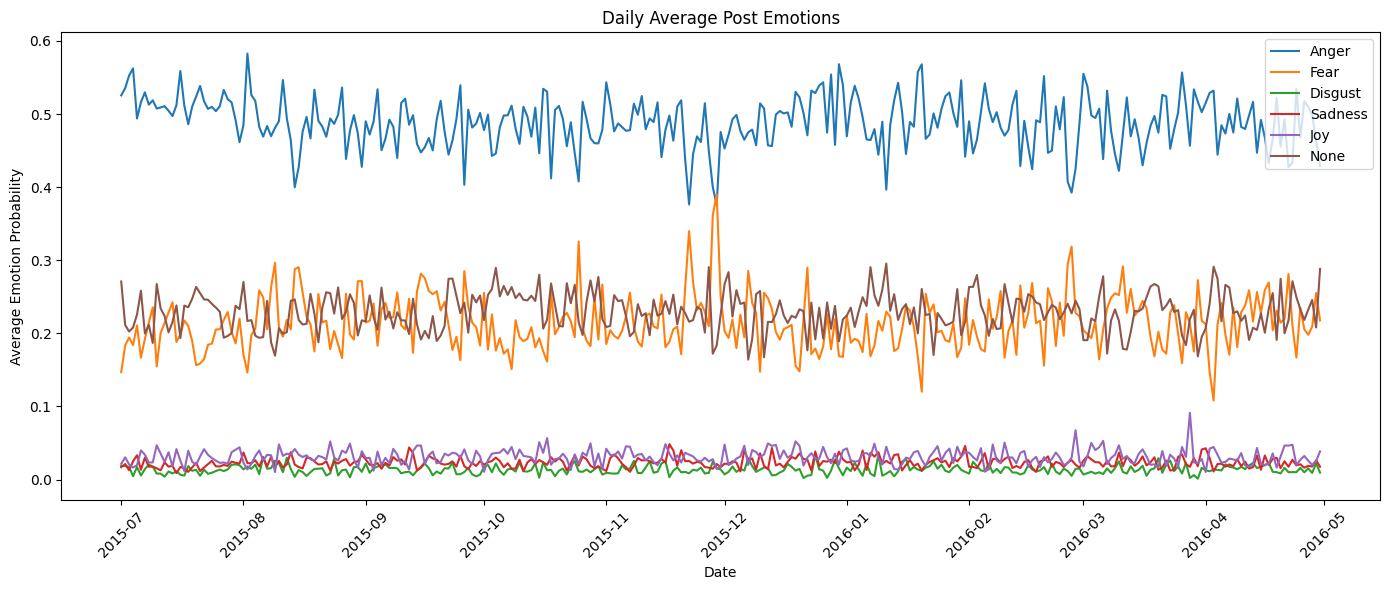

In [6]:
daily_emotions_p = (
    sentiments_filtered
    .groupby(pd.Grouper(key='CreatedAt', freq='D'))[emotion_cols_p]
    .mean()
    .reset_index()
    .rename(columns={'CreatedAt': 'Date'})
)

plt.figure(figsize=(14,6))
for col in emotion_cols_p:
    plt.plot(
        daily_emotions_p['Date'],
        daily_emotions_p[col],
        label=col.replace("_p", "").capitalize()
    )

plt.xlabel("Date")
plt.ylabel("Average Emotion Probability")
plt.title("Daily Average Post Emotions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


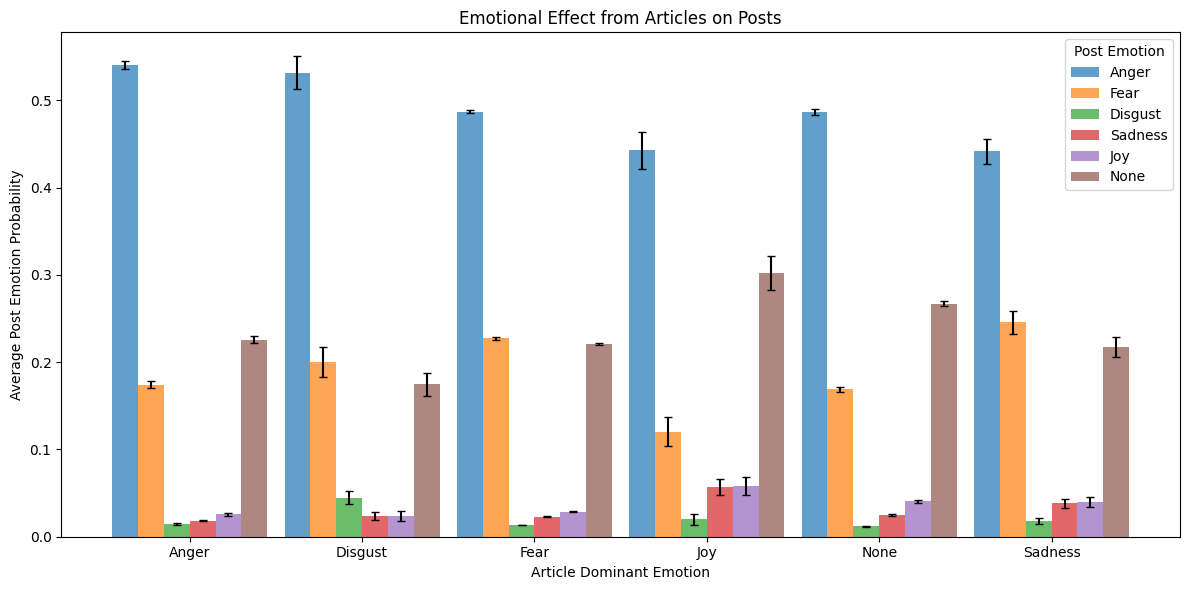

In [7]:
grouped = sentiments_filtered.groupby("dominant_emotion_a")[emotion_cols_p]
avg_post_emotions = grouped.mean()
sem_post_emotions = grouped.sem()

avg_post_emotions.index = avg_post_emotions.index.str.capitalize()
sem_post_emotions.index = sem_post_emotions.index.str.capitalize()
post_labels = [e.replace("_p","").capitalize() for e in emotion_cols_p]

x = np.arange(len(avg_post_emotions))
width = 0.15

plt.figure(figsize=(12,6))
for i, col in enumerate(emotion_cols_p):
    plt.bar(
        x + i*width,
        avg_post_emotions[col],
        width=width,
        alpha=0.7,
        yerr=sem_post_emotions[col],
        capsize=3,
        label=post_labels[i]
    )
plt.xlabel("Article Dominant Emotion")
plt.ylabel("Average Post Emotion Probability")
plt.title("Emotional Effect from Articles on Posts")
plt.xticks(x + width*(len(post_labels)/2 - 0.5), avg_post_emotions.index)
plt.legend(title="Post Emotion")
plt.tight_layout()
plt.show()


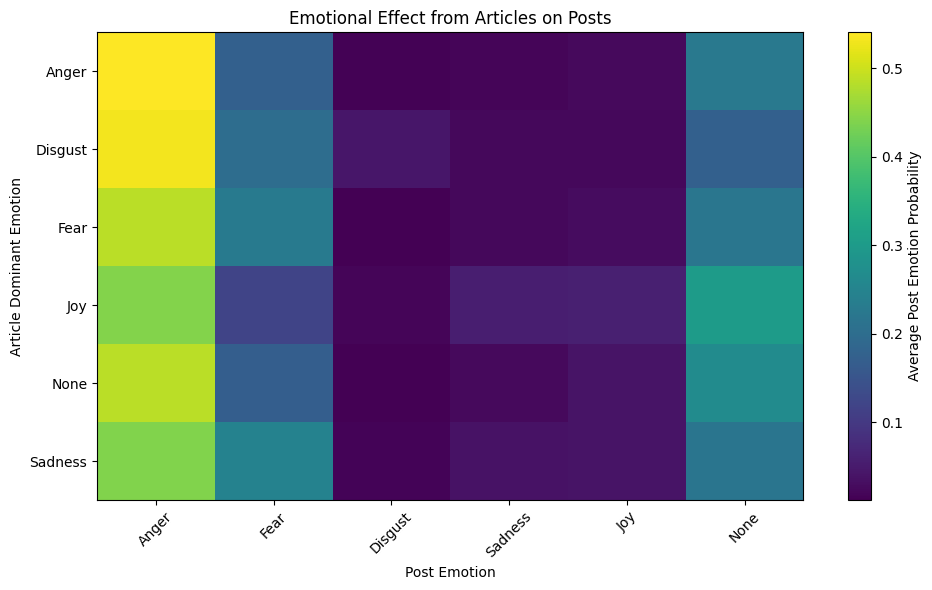

In [8]:
emotion_transition = sentiments_filtered.groupby("dominant_emotion_a")[emotion_cols_p].mean().reset_index()

plt.figure(figsize=(10,6))
plt.imshow(emotion_transition[emotion_cols_p], aspect='auto')
plt.colorbar(label="Average Post Emotion Probability")
plt.xticks(range(len(emotion_cols_p)), [e.replace("_p","").capitalize() for e in emotion_cols_p], rotation=45)
plt.yticks(range(len(emotion_transition)), emotion_transition["dominant_emotion_a"])
plt.xlabel("Post Emotion")
plt.ylabel("Article Dominant Emotion")
plt.title("Emotional Effect from Articles on Posts")
plt.tight_layout()
plt.show()